# Проверяем скорость поиска по вектоорам размерности 512 с RuCLIP на таблицах .lance с индексом IVF-PQ и без него.

In [1]:
!pip install pyarrow pandas lancedb numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 10.7 MB/s eta 0:00:00


In [2]:
### !pip install lancedb

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq # как тут приебенить паркеты?

import duckdb
import lancedb



500k таблица.

In [4]:
# Пример данных
db_path = 'database_500k'
db = lancedb.connect(db_path)


# 512 dim vectors
data = [{"vector": row, "item": f"item {i}"}
    for i, row in enumerate(np.random.random((5*10**5, 512)).astype('float32'))]


# Add the vectors to a table
tbl500k = db.create_table("vectors_500k", data=data)

data = tbl.to_pandas()
print(data)


                                                   vector         item
0       [0.113929324, 0.9547711, 0.6191746, 0.20707156...       item 0
1       [0.4796832, 0.665842, 0.30835375, 0.72862047, ...       item 1
2       [0.8090277, 0.41409236, 0.78564274, 0.20310463...       item 2
3       [0.9923177, 0.36959457, 0.5439635, 0.08953912,...       item 3
4       [0.085241556, 0.82717204, 0.73578936, 0.869536...       item 4
...                                                   ...          ...
499995  [0.41755426, 0.082778946, 0.18439971, 0.449081...  item 499995
499996  [0.8549068, 0.2911803, 0.30101898, 0.32842723,...  item 499996
499997  [0.44653672, 0.3597746, 0.72959524, 0.98284566...  item 499997
499998  [0.23060454, 0.3418701, 0.3929494, 0.6750906, ...  item 499998
499999  [0.7132438, 0.22592242, 0.9641849, 0.5504515, ...  item 499999

[500000 rows x 2 columns]


Без индекса total: 915 ms

In [10]:
%%time
random_vector = np.random.random((512))
tbl500k.search(random_vector) \
    .limit(10) \
    .nprobes(20) \
    .refine_factor(10) \
    .to_pandas()


CPU times: user 533 ms, sys: 382 ms, total: 915 ms
Wall time: 483 ms


,vector,item,_distance
0,"[0.3053472, 0.83220434, 0.91770893, 0.38270202...",item 166405,64.640152
1,"[0.7330841, 0.1024956, 0.8172986, 0.10021456, ...",item 31300,65.197701
2,"[0.49970514, 0.4635697, 0.19399738, 0.69973946...",item 210661,65.856018
3,"[0.6343247, 0.40136668, 0.16041288, 0.87518173...",item 248166,66.197769
4,"[0.44704142, 0.69359833, 0.19197747, 0.9059872...",item 442519,66.223335
5,"[0.6448117, 0.58236897, 0.7266935, 0.38524252,...",item 147750,66.436752
6,"[0.33419406, 0.49063045, 0.14229289, 0.2253958...",item 189319,66.641350
7,"[0.010497499, 0.8314923, 0.3682578, 0.8870309,...",item 373554,66.651375
8,"[0.107527696, 0.88788897, 0.47408256, 0.551138...",item 11486,66.791344
9,"[0.9195508, 0.011783997, 0.17036997, 0.0014364...",item 20305,66.868973


from matplotlib import pyplot as plt
_df_0['_distance'].plot(kind='hist', bins=20, title='_distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['_distance']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': '_distance'}, axis=1)
              .sort_values('_distance', ascending=True))
  xs = counted['_distance']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('_distance', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('_distance')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['_distance'].plot(kind='line', figsize=(8, 4), title='_distance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [12]:
from tqdm import tqdm

# Создание индекса IVF_PQ с метрикой cosine similarity и использованием CUDA
with tqdm(total=1, desc="index") as pbar:
  tbl500k.create_index(
      metric='cosine',
      num_partitions=256,
      num_sub_vectors=32,
      accelerator='cuda'
  )
  pbar.update(1)

 22%|██▏       | 11/50 [00:04<00:14,  2.70it/s]


0it [00:00, ?it/s]

index: 100%|██████████| 1/1 [03:16<00:00, 196.71s/it]


# С индексом **total: 23.6 ms**

In [16]:
%%time
random_vector = np.random.random((512))
tbl500k.search(random_vector) \
    .limit(10) \
    .nprobes(20) \
    .refine_factor(10) \
    .to_pandas()

CPU times: user 21.4 ms, sys: 2.2 ms, total: 23.6 ms
Wall time: 38.3 ms


,vector,item,_distance
0,"[0.16206317, 0.71622914, 0.9933739, 0.7627233,...",item 224978,0.200557
1,"[0.3981489, 0.9822786, 0.22645308, 0.24999647,...",item 384960,0.201218
2,"[0.74591005, 0.80818224, 0.3243394, 0.61479944...",item 276213,0.201310
3,"[0.92553884, 0.23935454, 0.40222895, 0.9713405...",item 189895,0.202318
4,"[0.21832478, 0.26891634, 0.86052275, 0.5853233...",item 409363,0.203032
5,"[0.99922, 0.62234265, 0.101836994, 0.54085493,...",item 409594,0.204458
6,"[0.97851205, 0.71102595, 0.1011979, 0.04492084...",item 71022,0.206131
7,"[0.4386279, 0.011651132, 0.025083125, 0.281410...",item 274266,0.206439
8,"[0.9334789, 0.92187315, 0.7445134, 0.64338636,...",item 194977,0.206738
9,"[0.085285425, 0.28128055, 0.5875558, 0.2662147...",item 155171,0.206939


# Таблица 1M векторов

In [18]:
# Пример данных
db_path = 'database_1M'
db = lancedb.connect(db_path)


# 512 dim vectors
data = [{"vector": row, "item": f"item {i}"}
    for i, row in enumerate(np.random.random((1*10**6, 512)).astype('float32'))]


# Add the vectors to a table
tbl1M = db.create_table("vectors_1M", data=data)

data = tbl1M.to_pandas()
print(data)


                                                   vector         item
0       [0.5478199, 0.8567436, 0.09525349, 0.863602, 0...       item 0
1       [0.9430089, 0.6443411, 0.37431848, 0.51719874,...       item 1
2       [0.54032254, 0.8071549, 0.940291, 0.5202549, 0...       item 2
3       [0.603627, 0.9558841, 0.415479, 0.28237933, 0....       item 3
4       [0.66839707, 0.26183516, 0.7923934, 0.23683847...       item 4
...                                                   ...          ...
999995  [0.07244526, 0.67789054, 0.24156408, 0.3229350...  item 999995
999996  [0.15339568, 0.6262225, 0.26029333, 0.02250642...  item 999996
999997  [0.9926309, 0.3346375, 0.7621276, 0.35206494, ...  item 999997
999998  [0.5651333, 0.036956914, 0.9547814, 0.10393341...  item 999998
999999  [0.6769593, 0.32937992, 0.5179093, 0.41830423,...  item 999999

[1000000 rows x 2 columns]


Без индекса *total: 1.98 s*

In [19]:
%%time
random_vector = np.random.random((512))
tbl1M.search(random_vector) \
    .limit(10) \
    .nprobes(20) \
    .refine_factor(10) \
    .to_pandas()


CPU times: user 892 ms, sys: 1.09 s, total: 1.98 s
Wall time: 5.8 s


,vector,item,_distance
0,"[0.8835063, 0.46229112, 0.28138798, 0.921306, ...",item 904693,65.552872
1,"[0.7424377, 0.49729845, 0.9945593, 0.49055597,...",item 449970,67.069687
2,"[0.7500007, 0.4124824, 0.10566698, 0.33960566,...",item 191286,67.074844
3,"[0.5304451, 0.6155314, 0.027324814, 0.43077365...",item 723742,67.662064
4,"[0.21863794, 0.6449565, 0.5960134, 0.7866914, ...",item 953671,67.797852
5,"[0.19767529, 0.8079899, 0.26015037, 0.14415674...",item 450622,67.829903
6,"[0.6840944, 0.3977966, 0.8798055, 0.5566474, 0...",item 480337,67.918892
7,"[0.91692764, 0.40737805, 0.5905814, 0.983992, ...",item 693555,68.075531
8,"[0.11975864, 0.9436561, 0.23036058, 0.7765162,...",item 167012,68.125862
9,"[0.40138158, 0.5259684, 0.37802422, 0.42811522...",item 201494,68.161957


С индексом


In [20]:
# Создание индекса IVF_PQ с метрикой cosine similarity и использованием CUDA
with tqdm(total=1, desc="index") as pbar:
  tbl1M.create_index(
      metric='cosine',
      num_partitions=256,
      num_sub_vectors=32,
      accelerator='cuda'
  )
  pbar.update(1)

 20%|██        | 10/50 [00:04<00:17,  2.32it/s]


0it [00:00, ?it/s]

index: 100%|██████████| 1/1 [04:17<00:00, 257.32s/it]


In [37]:
%%time
random_vector = np.random.random((512))
df1 = tbl1M.search(random_vector) \
    .limit(10) \
    .nprobes(1) \
    .refine_factor(10) \
    .to_pandas()



mean_value = df1['_distance'].mean()

print(f"Среднее арифметическое значение поля 'column_name': {mean_value}")


Среднее арифметическое значение поля 'column_name': 0.22172459959983826
CPU times: user 13.6 ms, sys: 2.87 ms, total: 16.5 ms
Wall time: 20.6 ms


In [33]:
%%time
random_vector = np.random.random((512))
tbl1M.search(random_vector) \
    .limit(10) \
    .nprobes(100) \
    .refine_factor(10) \
    .to_pandas()


CPU times: user 72.5 ms, sys: 2.13 ms, total: 74.6 ms
Wall time: 42.3 ms


,vector,item,_distance
0,"[0.19007722, 0.05262312, 0.9607386, 0.13055232...",item 964700,0.187970
1,"[0.3491733, 0.3867973, 0.94864756, 0.44618425,...",item 478649,0.188751
2,"[0.65209204, 0.37452665, 0.9671023, 0.5092147,...",item 456723,0.192547
3,"[0.55224264, 0.21725288, 0.69322526, 0.5848855...",item 362231,0.192650
4,"[0.08128049, 0.91150475, 0.48243213, 0.2030148...",item 479023,0.197098
5,"[0.743445, 0.954115, 0.037039503, 0.19714917, ...",item 565385,0.197220
6,"[0.7384595, 0.924546, 0.49367413, 0.37128708, ...",item 194353,0.197556
7,"[0.45940664, 0.2760417, 0.30484766, 0.96919304...",item 667962,0.197929
8,"[0.60561246, 0.341404, 0.9390337, 0.5856439, 0...",item 790159,0.198251
9,"[0.1501768, 0.55581117, 0.28619632, 0.2188696,...",item 606148,0.198820


In [23]:
%%time
random_vector = np.random.random((512))
tbl1M.search(random_vector) \
    .limit(10) \
    .nprobes(250) \
    .refine_factor(10) \
    .to_pandas()


CPU times: user 165 ms, sys: 28.2 ms, total: 193 ms
Wall time: 103 ms


,vector,item,_distance
0,"[0.61925685, 0.98802865, 0.6932715, 0.32674757...",item 759971,0.189754
1,"[0.3732637, 0.26652282, 0.9281812, 0.34290028,...",item 215869,0.198207
2,"[0.6296934, 0.418006, 0.4085859, 0.22445486, 0...",item 489258,0.199292
3,"[0.9976056, 0.4980363, 0.7353084, 0.1594245, 0...",item 233476,0.201562
4,"[0.34384793, 0.27174225, 0.84878695, 0.8982845...",item 853703,0.202358
5,"[0.28420156, 0.57985705, 0.019554218, 0.971955...",item 8217,0.202979
6,"[0.2349771, 0.4941706, 0.33518445, 0.7690539, ...",item 595012,0.204190
7,"[0.69683737, 0.6582864, 0.6240344, 0.17871702,...",item 312546,0.204643
8,"[0.06987648, 0.9710361, 0.52851564, 0.56664395...",item 187894,0.204755
9,"[0.86371374, 0.13752872, 0.007660112, 0.483789...",item 714530,0.205477


In [24]:
%%time
random_vector = np.random.random((512))
tbl1M.search(random_vector) \
    .limit(10) \
    .nprobes(500) \
    .refine_factor(10) \
    .to_pandas()


CPU times: user 171 ms, sys: 5.93 ms, total: 177 ms
Wall time: 108 ms


,vector,item,_distance
0,"[0.10611217, 0.80981636, 0.46652403, 0.3952917...",item 334575,0.182331
1,"[0.4939251, 0.97608644, 0.720157, 0.1680937, 0...",item 984627,0.198023
2,"[0.10800513, 0.7319431, 0.9420815, 0.45747536,...",item 290009,0.198234
3,"[0.451908, 0.36651662, 0.09688736, 0.9498582, ...",item 621745,0.200068
4,"[0.09824427, 0.015194164, 0.5474722, 0.7482044...",item 514632,0.200144
5,"[0.07458637, 0.36229894, 0.3625058, 0.36969453...",item 999722,0.200248
6,"[0.3626644, 0.30652827, 0.3285846, 0.001174966...",item 837380,0.200877
7,"[0.80185765, 0.5808149, 0.40986332, 0.7845754,...",item 493982,0.201816
8,"[0.8910094, 0.5141383, 0.53423077, 0.80415535,...",item 525532,0.202933
9,"[0.7537489, 0.8364961, 0.09337844, 0.8229172, ...",item 455069,0.204096


In [30]:
%%time
random_vector = np.random.random((512))
tbl1M.search(random_vector) \
    .limit(10) \
    .nprobes(5000) \
    .refine_factor(10000) \
    .to_pandas()


CPU times: user 3.03 s, sys: 1.06 s, total: 4.09 s
Wall time: 3.71 s


,vector,item,_distance
0,"[0.05729421, 0.24350755, 0.8826634, 0.82737416...",item 155058,0.186182
1,"[0.37619376, 0.036342185, 0.78505945, 0.949471...",item 485893,0.188134
2,"[0.5310356, 0.6298525, 0.27014816, 0.60502887,...",item 251824,0.190247
3,"[0.31240785, 0.45146477, 0.7786034, 0.6842128,...",item 391045,0.191826
4,"[0.62549096, 0.33356416, 0.5891876, 0.6316487,...",item 638125,0.191847
5,"[0.692595, 0.8506028, 0.46686354, 0.9344777, 0...",item 574224,0.193152
6,"[0.52166986, 0.16984786, 0.9038065, 0.8439049,...",item 96641,0.194358
7,"[0.79513013, 0.6186393, 0.68175906, 0.51826125...",item 334629,0.195138
8,"[0.20305261, 0.5809045, 0.64545155, 0.7293829,...",item 907114,0.195208
9,"[0.8008497, 0.13559347, 0.9002476, 0.9733874, ...",item 195943,0.195299


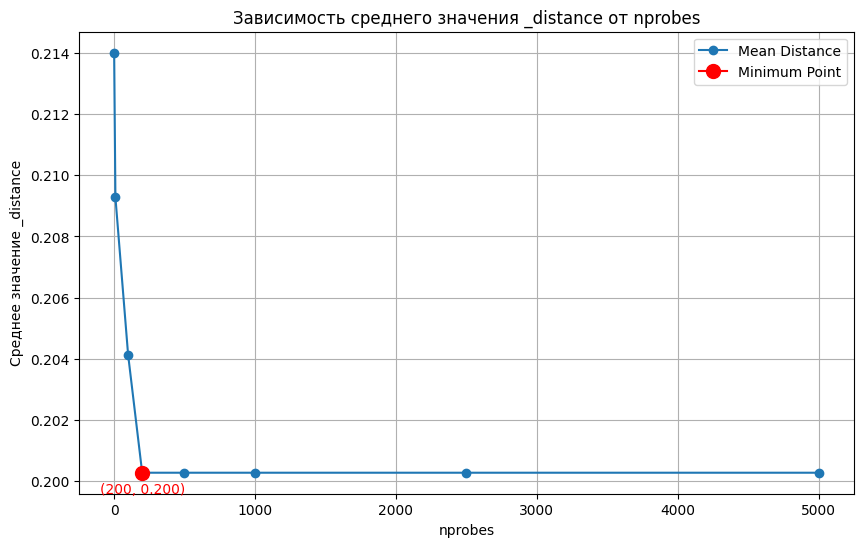

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Предположим, что у вас уже есть созданный объект tbl1M
random_vector = np.random.random((512))

nprobes_values = [1, 10, 100, 200, 500, 1000, 2500, 5000]
mean_distances = []

for nprobes in nprobes_values:
    df1 = tbl1M.search(random_vector) \
        .limit(10) \
        .nprobes(nprobes) \
        .refine_factor(10) \
        .to_pandas()

    mean_value = df1['_distance'].mean()
    mean_distances.append(mean_value)

# Найдем индекс минимального значения
min_index = np.argmin(mean_distances)
min_nprobes = nprobes_values[min_index]
min_value = mean_distances[min_index]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(nprobes_values, mean_distances, marker='o', linestyle='-', label='Mean Distance')

# Выделение точки минимума
plt.plot(min_nprobes, min_value, marker='o', color='red', markersize=10, label='Minimum Point')
plt.annotate(f'({min_nprobes}, {min_value:.3f})',
             (min_nprobes, min_value),
             textcoords="offset points",
             xytext=(0,-15),
             ha='center',
             color='red')

# Подписи и оформление
plt.xlabel('nprobes')
plt.ylabel('Среднее значение _distance')
plt.title('Зависимость среднего значения _distance от nprobes')
plt.grid(True)

plt.legend()
plt.show()


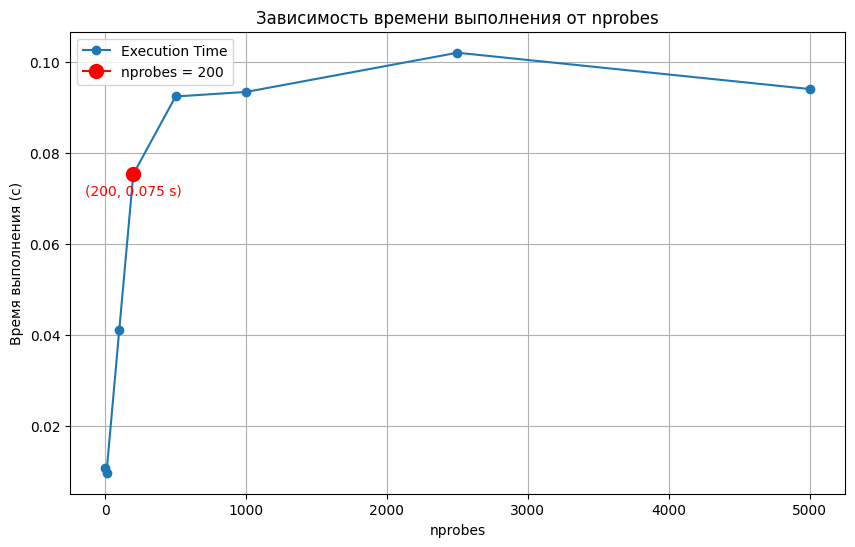

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Предположим, что у вас уже есть созданный объект tbl1M
random_vector = np.random.random((512))

nprobes_values = [1, 10, 100, 200, 500, 1000, 2500, 5000]
execution_times = []

for nprobes in nprobes_values:
    start_time = time.time()
    df1 = tbl1M.search(random_vector) \
        .limit(10) \
        .nprobes(nprobes) \
        .refine_factor(10) \
        .to_pandas()
    end_time = time.time()

    execution_time = end_time - start_time
    execution_times.append(execution_time)

# Найдем индекс для nprobes = 200
highlight_index = nprobes_values.index(200)
highlight_nprobes = nprobes_values[highlight_index]
highlight_time = execution_times[highlight_index]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(nprobes_values, execution_times, marker='o', linestyle='-', label='Execution Time')

# Выделение точки для nprobes = 200
plt.plot(highlight_nprobes, highlight_time, marker='o', color='red', markersize=10, label='nprobes = 200')
plt.annotate(f'({highlight_nprobes}, {highlight_time:.3f} s)',
             (highlight_nprobes, highlight_time),
             textcoords="offset points",
             xytext=(0,-15),
             ha='center',
             color='red')

# Подписи и оформление
plt.xlabel('nprobes')
plt.ylabel('Время выполнения (с)')
plt.title('Зависимость времени выполнения от nprobes')
plt.grid(True)

plt.legend()
plt.show()
